In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
clean = pd.read_csv('clean_sales_8811.csv')

In [5]:
clean.head()

,year,no_of_cylinders,horsepower,body_condition,mechanical_condition,color_Beige,color_Black,color_Blue,color_Brown,color_Burgundy,...,body_type_Van,body_type_Wagon,transmission_type_Automatic Transmission,transmission_type_Manual Transmission,fuel_type_Diesel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,miles,price_usd
0,2013,6,-1,3,4,0,0,0,0,0,...,0,0,1,0,0,0,1,0,104011.29,7079.65
1,2018,8,4,3,4,0,0,0,0,0,...,0,0,1,0,0,0,1,0,24233.47,29952.35
2,2014,6,4,3,4,0,0,1,0,0,...,0,0,1,0,0,0,1,0,124274.20,21238.94
3,2018,8,6,3,4,0,0,0,0,0,...,0,0,1,0,0,0,1,0,16777.02,244792.38
4,2020,4,0,3,4,0,0,0,0,0,...,0,1,0,1,0,0,1,0,42874.60,8985.70


In [6]:
clean.shape

(8811, 43)

In [7]:
def train(df, model):
    X = df.drop(columns='price_usd')
    y = df[f'price_usd']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42, shuffle=True)
    
    model.fit(X_train, y_train)
    
    return model, X_test, y_test

In [8]:
def metrics(df, model):
    
    model, X_test, y_test = train(df, model)
    pred = model.predict(X_test)
    
    
    mean = df['price_usd'].mean().round(2)
    mae_goal = (mean * .05).round(2)
    mae = mean_absolute_error(y_test, pred).round(2)
    mae_diff = (mae - mae_goal).round(2)
    mape =  ((mae / mean) * 100).round(2)
    mean_abs_diff = np.mean(np.abs(np.diff(y_test)))
    mase = (mae / mean_abs_diff).round(2)
    mse = mean_squared_error(y_test, pred).round(2)
    rmse = np.sqrt(mse).round(2)
    r2 = r2_score(y_test, pred).round(2)

    print(f"""
Data Set Mean: {mean}\n
MAE Goal: {mae_goal}  MAE: {mae}  Difference: {mae_diff}\n
MAPE: {mape}%  MASE: {mase}\n
MSE: {mse}  RMSE: {rmse}\n
R2: {r2}
""")

In [9]:
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

metrics(clean, model)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 17272.82  Difference: 14953.79

MAPE: 37.24%  MASE: 0.34

MSE: 828601558.0  RMSE: 28785.44

R2: 0.76



In [10]:
n_est = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_feat = [1.0, 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 50, num = 11)]
max_depth.append(None)
min_samp_split = [2, 5, 10, 20]
min_samp_leaf = [1, 2, 4, 8]
bootstrap = [True, False]

r_grid = {
    'n_estimators': n_est,
    'max_features': max_feat,
    'max_depth': max_depth,
    'min_samples_split': min_samp_split,
    'min_samples_leaf': min_samp_leaf,
    'bootstrap': bootstrap
}

In [11]:
model_random = RandomizedSearchCV(
    estimator = model, param_distributions = r_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

model_random, X_test, y_test = train(clean, model_random)

model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 18,
 'bootstrap': True}

In [13]:
best_random = model_random.best_estimator_

metrics(clean, best_random)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 14764.14  Difference: 12445.11

MAPE: 31.83%  MASE: 0.29

MSE: 660506554.15  RMSE: 25700.32

R2: 0.81



In [14]:
p_grid = {
    'n_estimators': [800, 850, 900],
    'max_features': ['sqrt', 2, 3],
    'max_depth': [18, 19, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

model_grid = GridSearchCV(estimator = model, param_grid = p_grid, cv = 3, n_jobs = -1, verbose = 2)

model_grid, X_test, y_test = train(clean, model_grid)

model_grid.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


{'bootstrap': True,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [15]:
best_grid = model_grid.best_estimator_

metrics(clean, best_grid)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 14764.7  Difference: 12445.67

MAPE: 31.83%  MASE: 0.29

MSE: 660856506.11  RMSE: 25707.13

R2: 0.81



<Axes: >

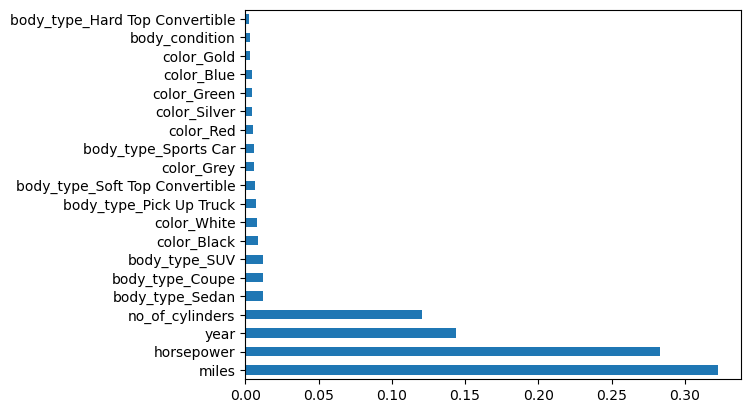

In [16]:
feat_importance = pd.Series(best_grid.feature_importances_, index=X_test.columns)
feat_importance.nlargest(20).plot(kind='barh')

Even with a more exhaustive search, we land in the same ballpark as our random hyperparameter search.  We have an error rate of around **31.83%** of the data set's average vehicle price. My thought is our price ranges are still way too far apart to get a precise prediction. I am going to reduce the data set to include only values within the IQR.

In [17]:
high = clean['price_usd'].quantile(.75)
low = clean['price_usd'].quantile(.25)
spread = (low, high)
spread

(13070.12, 50646.7)

In [18]:
clean75 = clean[(clean['price_usd'] > low) & (clean['price_usd'] < high)]
clean75.shape

(4361, 43)

In [19]:
model75 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

metrics(clean75, model75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6633.11  Difference: 5277.1

MAPE: 24.46%  MASE: 0.56

MSE: 69331590.33  RMSE: 8326.56

R2: 0.36



In [20]:
model_random75 = RandomizedSearchCV(
    estimator = model, param_distributions = r_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

model_random75, X_test, y_test = train(clean75, model_random75)

model_random75.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [21]:
best_random75 = model_random75.best_estimator_

metrics(clean75, best_random75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6358.13  Difference: 5002.12

MAPE: 23.44%  MASE: 0.53

MSE: 66678381.06  RMSE: 8165.68

R2: 0.39



In [22]:
p_grid = {
    'n_estimators': [800, 850, 900],
    'max_features': ['sqrt', 2, 3],
    'max_depth': [18, 19, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

model_grid75 = GridSearchCV(estimator = model, param_grid = p_grid, cv = 3, n_jobs = -1, verbose = 2)

model_grid75, X_test, y_test = train(clean75, model_grid75)

model_grid75.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


{'bootstrap': True,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 900}

In [23]:
best_grid75 = model_grid.best_estimator_

metrics(clean75, best_grid75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6334.14  Difference: 4978.13

MAPE: 23.36%  MASE: 0.53

MSE: 64951779.93  RMSE: 8059.27

R2: 0.4



<Axes: >

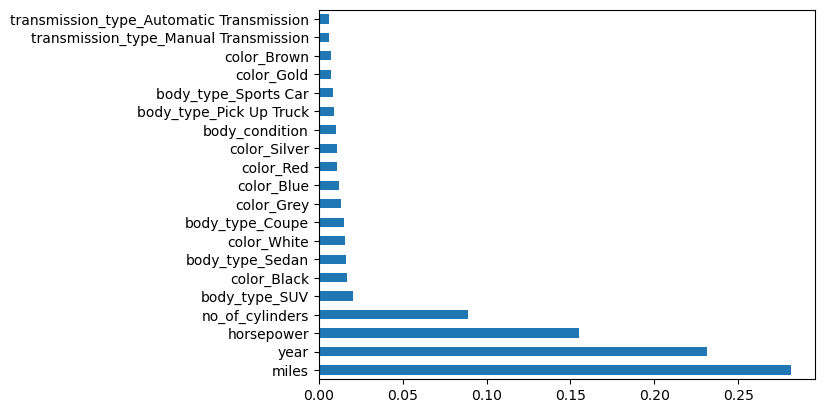

In [24]:
feat_importance75 = pd.Series(best_grid75.feature_importances_, index=X_test.columns)
feat_importance75.nlargest(20).plot(kind='barh')

Even after reducing the data set by nearly 50%, our metrics only slightly improved.  Instead of having a MAE value that is 31.64% of the data set's mean, we have a MAE value that is 24.32% of the mean.  In practical terms, losing more than 7000 on a sale of a 

In [26]:
reduced_columns = ['price_usd']
reduced_columns75 = ['price_usd']

for x in feat_importance.nlargest(10).index:
    reduced_columns.append(x)

for x in feat_importance75.nlargest(10).index:
    reduced_columns75.append(x)

reduced_columns, reduced_columns75

(['price_usd',
  'miles',
  'horsepower',
  'year',
  'no_of_cylinders',
  'body_type_Sedan',
  'body_type_Coupe',
  'body_type_SUV',
  'color_Black',
  'color_White',
  'body_type_Pick Up Truck'],
 ['price_usd',
  'miles',
  'year',
  'horsepower',
  'no_of_cylinders',
  'body_type_SUV',
  'color_Black',
  'body_type_Sedan',
  'color_White',
  'body_type_Coupe',
  'color_Grey'])

In [27]:
clean_reduced = clean[reduced_columns]
clean_reduced75 = clean75[reduced_columns75]

In [28]:
metrics(clean_reduced, best_grid)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 14645.48  Difference: 12326.45

MAPE: 31.58%  MASE: 0.29

MSE: 656747850.61  RMSE: 25627.09

R2: 0.81



In [29]:
metrics(clean_reduced75, best_grid75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6474.08  Difference: 5118.07

MAPE: 23.87%  MASE: 0.54

MSE: 71067303.27  RMSE: 8430.14

R2: 0.35

